In [1]:
import os

from datetime import datetime

import torch
from torch.utils.tensorboard.writer import SummaryWriter
from quinnVAE.heidenreich.vae import VAE
from tqdm import tqdm
from torchvision import datasets
from torchvision.transforms import v2


batch_size = 128
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Lambda(lambda x: x.view(-1) - 0.5),
    ]
)

# Download and load the training data
train_data = datasets.MNIST(
    "~/.pytorch/MNIST_data/",
    download=True,
    train=True,
    transform=transform,
)
# Download and load the test data
test_data = datasets.MNIST(
    "~/.pytorch/MNIST_data/",
    download=True,
    train=False,
    transform=transform,
)

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
)

In [2]:
learning_rate = 1e-3
weight_decay = 1e-2
num_epochs = 50
latent_dim = 2
hidden_dim = 512

device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
model = VAE(input_dim=784, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=weight_decay)
writer = SummaryWriter(f'runs/mnist/vae_{datetime.now().strftime("%Y%m%d-%H%M%S")}')

In [3]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    """
    Trains the model on the given data.

    Args:
        model (nn.Module): The model to train.
        dataloader (torch.utils.data.DataLoader): The data loader.
        loss_fn: The loss function.
        optimizer: The optimizer.
    """
    model.train()  # Set the model to training mode

    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx

        data = data.to(device)

        optimizer.zero_grad()  # Zero the gradients

        output = model(data)  # Forward pass
        loss = output.loss

        loss.backward()

        if n_upd % 100 == 0:
            # Calculate and log gradient norms
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1.0 / 2)

            print(
                f"Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {output.loss_recon.item():.4f}, KL: {output.loss_kl.item():.4f}) Grad: {total_norm:.4f}"
            )

            if writer is not None:
                global_step = n_upd
                writer.add_scalar("Loss/Train", loss.item(), global_step)
                writer.add_scalar(
                    "Loss/Train/BCE", output.loss_recon.item(), global_step
                )
                writer.add_scalar("Loss/Train/KLD", output.loss_kl.item(), global_step)
                writer.add_scalar("GradNorm/Train", total_norm, global_step)

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()  # Update the model parameters

    return prev_updates + len(dataloader)


def test(model, dataloader, cur_step, writer=None):
    """
    Tests the model on the given data.

    Args:
        model (nn.Module): The model to test.
        dataloader (torch.utils.data.DataLoader): The data loader.
        cur_step (int): The current step.
        writer: The TensorBoard writer.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0

    with torch.no_grad():
        for data, target in tqdm(dataloader, desc="Testing"):
            data = data.to(device)
            data = data.view(data.size(0), -1)  # Flatten the data

            output = model(data, compute_loss=True)  # Forward pass

            test_loss += output.loss.item()
            test_recon_loss += output.loss_recon.item()
            test_kl_loss += output.loss_kl.item()

    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    print(
        f"====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f})"
    )

    if writer is not None:
        writer.add_scalar("Loss/Test", test_loss, global_step=cur_step)
        writer.add_scalar(
            "Loss/Test/BCE", output.loss_recon.item(), global_step=cur_step
        )
        writer.add_scalar("Loss/Test/KLD", output.loss_kl.item(), global_step=cur_step)

        # Log reconstructions
        writer.add_images(
            "Test/Reconstructions",
            output.x_recon.view(-1, 1, 28, 28),
            global_step=cur_step,
        )
        writer.add_images(
            "Test/Originals", data.view(-1, 1, 28, 28), global_step=cur_step
        )

        # Log random samples from the latent space
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decode(z)
        writer.add_images(
            "Test/Samples", samples.view(-1, 1, 28, 28), global_step=cur_step
        )

In [4]:
prev_updates = 0
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)

Epoch 1/50


  1%|          | 3/469 [00:00<01:08,  6.78it/s]

Step 0 (N samples: 0), Loss: 544.2146 (Recon: 544.0114, KL: 0.2032) Grad: 13.1824


 22%|██▏       | 103/469 [00:05<00:18, 19.35it/s]

Step 100 (N samples: 12,800), Loss: 187.4473 (Recon: 185.4421, KL: 2.0052) Grad: 24.6657


 43%|████▎     | 204/469 [00:10<00:13, 19.21it/s]

Step 200 (N samples: 25,600), Loss: 187.1016 (Recon: 184.9328, KL: 2.1688) Grad: 23.6801


 65%|██████▍   | 304/469 [00:16<00:08, 19.04it/s]

Step 300 (N samples: 38,400), Loss: 171.7283 (Recon: 167.9395, KL: 3.7888) Grad: 28.6603


 86%|████████▌ | 403/469 [00:21<00:03, 18.50it/s]

Step 400 (N samples: 51,200), Loss: 164.6601 (Recon: 160.1641, KL: 4.4960) Grad: 41.0074


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.22it/s]


====> Test set loss: 167.4316 (BCE: 163.1910, KLD: 4.2405)
Epoch 2/50


  7%|▋         | 34/469 [00:01<00:22, 19.43it/s]

Step 500 (N samples: 64,000), Loss: 160.8234 (Recon: 156.1327, KL: 4.6906) Grad: 75.3285


 29%|██▊       | 134/469 [00:06<00:16, 20.41it/s]

Step 600 (N samples: 76,800), Loss: 169.1712 (Recon: 164.3027, KL: 4.8685) Grad: 45.8944


 50%|█████     | 235/469 [00:11<00:11, 20.19it/s]

Step 700 (N samples: 89,600), Loss: 148.7914 (Recon: 143.4801, KL: 5.3113) Grad: 83.4246


 71%|███████▏  | 335/469 [00:16<00:06, 19.93it/s]

Step 800 (N samples: 102,400), Loss: 161.4592 (Recon: 156.3618, KL: 5.0975) Grad: 80.4291


 93%|█████████▎| 435/469 [00:21<00:01, 20.04it/s]

Step 900 (N samples: 115,200), Loss: 162.7505 (Recon: 157.4253, KL: 5.3252) Grad: 171.4797


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.05it/s]


====> Test set loss: 156.3435 (BCE: 151.0703, KLD: 5.2732)
Epoch 3/50


 14%|█▍        | 65/469 [00:03<00:19, 20.32it/s]

Step 1,000 (N samples: 128,000), Loss: 151.6716 (Recon: 146.4738, KL: 5.1978) Grad: 35.0859


 35%|███▌      | 166/469 [00:08<00:15, 19.76it/s]

Step 1,100 (N samples: 140,800), Loss: 144.6496 (Recon: 138.8870, KL: 5.7626) Grad: 81.4979


 57%|█████▋    | 266/469 [00:13<00:10, 19.59it/s]

Step 1,200 (N samples: 153,600), Loss: 147.7717 (Recon: 142.3327, KL: 5.4390) Grad: 89.2825


 78%|███████▊  | 366/469 [00:18<00:05, 19.91it/s]

Step 1,300 (N samples: 166,400), Loss: 150.4114 (Recon: 144.6884, KL: 5.7230) Grad: 37.3768


100%|█████████▉| 467/469 [00:23<00:00, 20.32it/s]

Step 1,400 (N samples: 179,200), Loss: 154.3348 (Recon: 148.6716, KL: 5.6632) Grad: 75.0562


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.94it/s]


====> Test set loss: 151.4348 (BCE: 145.7230, KLD: 5.7118)
Epoch 4/50


 21%|██        | 98/469 [00:04<00:18, 19.89it/s]

Step 1,500 (N samples: 192,000), Loss: 147.4694 (Recon: 141.7342, KL: 5.7352) Grad: 62.0906


 42%|████▏     | 195/469 [00:09<00:13, 19.64it/s]

Step 1,600 (N samples: 204,800), Loss: 142.8380 (Recon: 136.9396, KL: 5.8983) Grad: 47.1878


 63%|██████▎   | 296/469 [00:14<00:08, 20.13it/s]

Step 1,700 (N samples: 217,600), Loss: 148.4081 (Recon: 142.6886, KL: 5.7195) Grad: 86.4059


 85%|████████▍ | 397/469 [00:20<00:03, 20.01it/s]

Step 1,800 (N samples: 230,400), Loss: 144.8513 (Recon: 139.0040, KL: 5.8473) Grad: 58.9108


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.01it/s]


====> Test set loss: 148.8481 (BCE: 142.9969, KLD: 5.8512)
Epoch 5/50


  6%|▌         | 29/469 [00:01<00:21, 20.30it/s]

Step 1,900 (N samples: 243,200), Loss: 148.6723 (Recon: 142.5049, KL: 6.1674) Grad: 73.0769


 27%|██▋       | 128/469 [00:06<00:16, 20.35it/s]

Step 2,000 (N samples: 256,000), Loss: 145.9029 (Recon: 139.8387, KL: 6.0641) Grad: 75.1984


 48%|████▊     | 227/469 [00:11<00:12, 20.16it/s]

Step 2,100 (N samples: 268,800), Loss: 146.8291 (Recon: 140.7865, KL: 6.0427) Grad: 55.6721


 70%|██████▉   | 328/469 [00:16<00:07, 20.10it/s]

Step 2,200 (N samples: 281,600), Loss: 143.6470 (Recon: 137.6557, KL: 5.9913) Grad: 40.1990


 91%|█████████▏| 428/469 [00:21<00:02, 20.18it/s]

Step 2,300 (N samples: 294,400), Loss: 147.4237 (Recon: 141.1726, KL: 6.2510) Grad: 147.5600


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.83it/s]


====> Test set loss: 148.9785 (BCE: 142.8875, KLD: 6.0910)
Epoch 6/50


 12%|█▏        | 58/469 [00:02<00:20, 19.62it/s]

Step 2,400 (N samples: 307,200), Loss: 142.7689 (Recon: 136.7779, KL: 5.9910) Grad: 74.8817


 34%|███▍      | 160/469 [00:08<00:15, 20.36it/s]

Step 2,500 (N samples: 320,000), Loss: 149.1301 (Recon: 143.1214, KL: 6.0087) Grad: 80.3016


 55%|█████▌    | 259/469 [00:12<00:10, 20.14it/s]

Step 2,600 (N samples: 332,800), Loss: 141.0306 (Recon: 134.7727, KL: 6.2579) Grad: 105.8813


 76%|███████▋  | 358/469 [00:17<00:05, 20.44it/s]

Step 2,700 (N samples: 345,600), Loss: 147.7817 (Recon: 141.5863, KL: 6.1954) Grad: 106.9219


 98%|█████████▊| 458/469 [00:22<00:00, 19.86it/s]

Step 2,800 (N samples: 358,400), Loss: 149.4360 (Recon: 143.3102, KL: 6.1258) Grad: 87.6130


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.14it/s]


====> Test set loss: 147.0171 (BCE: 140.8863, KLD: 6.1308)
Epoch 7/50


 19%|█▉        | 90/469 [00:04<00:18, 20.30it/s]

Step 2,900 (N samples: 371,200), Loss: 139.3387 (Recon: 132.9887, KL: 6.3500) Grad: 101.1874


 41%|████      | 190/469 [00:09<00:14, 19.04it/s]

Step 3,000 (N samples: 384,000), Loss: 148.2483 (Recon: 141.9498, KL: 6.2985) Grad: 77.8567


 62%|██████▏   | 290/469 [00:14<00:09, 19.30it/s]

Step 3,100 (N samples: 396,800), Loss: 140.2451 (Recon: 133.9803, KL: 6.2648) Grad: 70.6337


 83%|████████▎ | 389/469 [00:19<00:04, 18.96it/s]

Step 3,200 (N samples: 409,600), Loss: 141.4327 (Recon: 135.2765, KL: 6.1562) Grad: 93.4463


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.68it/s]


====> Test set loss: 145.3877 (BCE: 139.2557, KLD: 6.1320)
Epoch 8/50


  4%|▍         | 19/469 [00:00<00:22, 20.13it/s]

Step 3,300 (N samples: 422,400), Loss: 148.0889 (Recon: 141.8395, KL: 6.2493) Grad: 66.3239


 26%|██▌       | 122/469 [00:06<00:17, 20.21it/s]

Step 3,400 (N samples: 435,200), Loss: 148.2170 (Recon: 141.9131, KL: 6.3040) Grad: 70.7244


 47%|████▋     | 221/469 [00:11<00:12, 19.84it/s]

Step 3,500 (N samples: 448,000), Loss: 146.5415 (Recon: 140.3293, KL: 6.2122) Grad: 77.8635


 68%|██████▊   | 320/469 [00:16<00:07, 20.17it/s]

Step 3,600 (N samples: 460,800), Loss: 137.7286 (Recon: 131.2437, KL: 6.4849) Grad: 151.6603


 90%|████████▉ | 421/469 [00:21<00:02, 18.89it/s]

Step 3,700 (N samples: 473,600), Loss: 137.4376 (Recon: 131.1741, KL: 6.2635) Grad: 89.6754


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.52it/s]


====> Test set loss: 145.4303 (BCE: 139.1224, KLD: 6.3079)
Epoch 9/50


 11%|█         | 52/469 [00:02<00:21, 19.02it/s]

Step 3,800 (N samples: 486,400), Loss: 142.4834 (Recon: 136.0372, KL: 6.4462) Grad: 116.6567


 32%|███▏      | 151/469 [00:07<00:15, 20.13it/s]

Step 3,900 (N samples: 499,200), Loss: 151.1425 (Recon: 144.6668, KL: 6.4757) Grad: 73.8059


 54%|█████▍    | 253/469 [00:12<00:10, 19.95it/s]

Step 4,000 (N samples: 512,000), Loss: 138.9431 (Recon: 132.5065, KL: 6.4365) Grad: 114.0271


 75%|███████▌  | 352/469 [00:17<00:05, 20.13it/s]

Step 4,100 (N samples: 524,800), Loss: 138.2915 (Recon: 132.0142, KL: 6.2773) Grad: 71.1134


 96%|█████████▌| 451/469 [00:22<00:00, 19.47it/s]

Step 4,200 (N samples: 537,600), Loss: 143.2462 (Recon: 136.9335, KL: 6.3127) Grad: 64.7402


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.96it/s]


====> Test set loss: 142.4209 (BCE: 136.0510, KLD: 6.3699)
Epoch 10/50


 17%|█▋        | 82/469 [00:04<00:19, 19.75it/s]

Step 4,300 (N samples: 550,400), Loss: 142.3480 (Recon: 135.8068, KL: 6.5412) Grad: 95.7493


 39%|███▉      | 184/469 [00:09<00:14, 20.14it/s]

Step 4,400 (N samples: 563,200), Loss: 136.9541 (Recon: 130.5787, KL: 6.3754) Grad: 84.6673


 60%|██████    | 283/469 [00:14<00:09, 19.51it/s]

Step 4,500 (N samples: 576,000), Loss: 144.5956 (Recon: 138.0863, KL: 6.5093) Grad: 71.4494


 82%|████████▏ | 383/469 [00:19<00:04, 18.61it/s]

Step 4,600 (N samples: 588,800), Loss: 151.1096 (Recon: 144.7164, KL: 6.3932) Grad: 145.1056


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.64it/s]


====> Test set loss: 143.8967 (BCE: 137.7087, KLD: 6.1879)
Epoch 11/50


  3%|▎         | 14/469 [00:00<00:22, 20.13it/s]

Step 4,700 (N samples: 601,600), Loss: 147.2277 (Recon: 140.8398, KL: 6.3879) Grad: 89.3779


 24%|██▍       | 114/469 [00:05<00:17, 19.94it/s]

Step 4,800 (N samples: 614,400), Loss: 140.1033 (Recon: 133.5426, KL: 6.5607) Grad: 71.9082


 46%|████▌     | 214/469 [00:10<00:13, 19.57it/s]

Step 4,900 (N samples: 627,200), Loss: 137.7570 (Recon: 131.2521, KL: 6.5049) Grad: 82.8966


 67%|██████▋   | 314/469 [00:15<00:07, 19.98it/s]

Step 5,000 (N samples: 640,000), Loss: 140.4533 (Recon: 133.8854, KL: 6.5679) Grad: 117.1291


 88%|████████▊ | 412/469 [00:20<00:02, 20.05it/s]

Step 5,100 (N samples: 652,800), Loss: 139.7347 (Recon: 133.1813, KL: 6.5533) Grad: 107.3116


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.88it/s]


====> Test set loss: 140.8718 (BCE: 134.3614, KLD: 6.5105)
Epoch 12/50


 10%|▉         | 46/469 [00:02<00:21, 19.97it/s]

Step 5,200 (N samples: 665,600), Loss: 140.9528 (Recon: 134.4000, KL: 6.5528) Grad: 85.5212


 31%|███       | 145/469 [00:07<00:16, 19.71it/s]

Step 5,300 (N samples: 678,400), Loss: 139.6548 (Recon: 133.3312, KL: 6.3236) Grad: 113.3009


 52%|█████▏    | 245/469 [00:12<00:11, 20.13it/s]

Step 5,400 (N samples: 691,200), Loss: 136.1581 (Recon: 129.6512, KL: 6.5070) Grad: 66.9289


 73%|███████▎  | 344/469 [00:17<00:06, 19.75it/s]

Step 5,500 (N samples: 704,000), Loss: 138.3361 (Recon: 131.8249, KL: 6.5112) Grad: 71.5716


 95%|█████████▌| 446/469 [00:22<00:01, 19.82it/s]

Step 5,600 (N samples: 716,800), Loss: 141.8253 (Recon: 135.0561, KL: 6.7692) Grad: 142.3506


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.74it/s]


====> Test set loss: 142.6803 (BCE: 136.1007, KLD: 6.5796)
Epoch 13/50


 16%|█▌        | 76/469 [00:03<00:19, 19.81it/s]

Step 5,700 (N samples: 729,600), Loss: 132.3281 (Recon: 125.8499, KL: 6.4782) Grad: 74.6861


 37%|███▋      | 175/469 [00:08<00:14, 19.91it/s]

Step 5,800 (N samples: 742,400), Loss: 143.4971 (Recon: 136.9735, KL: 6.5236) Grad: 73.3290


 59%|█████▊    | 275/469 [00:13<00:09, 19.76it/s]

Step 5,900 (N samples: 755,200), Loss: 139.7563 (Recon: 133.2281, KL: 6.5281) Grad: 98.3633


 80%|███████▉  | 375/469 [00:18<00:04, 19.96it/s]

Step 6,000 (N samples: 768,000), Loss: 149.5595 (Recon: 143.0318, KL: 6.5277) Grad: 206.3751


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.78it/s]


====> Test set loss: 140.7923 (BCE: 134.1709, KLD: 6.6214)
Epoch 14/50


  1%|▏         | 6/469 [00:00<00:24, 18.87it/s]

Step 6,100 (N samples: 780,800), Loss: 139.0802 (Recon: 132.3104, KL: 6.7698) Grad: 118.7758


 23%|██▎       | 107/469 [00:05<00:18, 20.01it/s]

Step 6,200 (N samples: 793,600), Loss: 140.3540 (Recon: 133.6630, KL: 6.6910) Grad: 102.7803


 44%|████▍     | 208/469 [00:10<00:13, 19.99it/s]

Step 6,300 (N samples: 806,400), Loss: 139.3153 (Recon: 132.8496, KL: 6.4657) Grad: 128.5188


 66%|██████▌   | 308/469 [00:15<00:08, 19.90it/s]

Step 6,400 (N samples: 819,200), Loss: 136.4456 (Recon: 129.9265, KL: 6.5191) Grad: 71.2697


 87%|████████▋ | 406/469 [00:20<00:03, 19.49it/s]

Step 6,500 (N samples: 832,000), Loss: 137.6809 (Recon: 131.1027, KL: 6.5781) Grad: 84.9719


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.89it/s]


====> Test set loss: 141.8149 (BCE: 135.2737, KLD: 6.5412)
Epoch 15/50


  8%|▊         | 38/469 [00:01<00:21, 19.80it/s]

Step 6,600 (N samples: 844,800), Loss: 136.3867 (Recon: 129.5650, KL: 6.8217) Grad: 106.8095


 29%|██▉       | 138/469 [00:06<00:16, 19.85it/s]

Step 6,700 (N samples: 857,600), Loss: 138.4234 (Recon: 131.8643, KL: 6.5590) Grad: 58.9280


 51%|█████     | 237/469 [00:11<00:11, 20.05it/s]

Step 6,800 (N samples: 870,400), Loss: 145.6417 (Recon: 139.0583, KL: 6.5834) Grad: 146.6373


 72%|███████▏  | 337/469 [00:16<00:06, 19.92it/s]

Step 6,900 (N samples: 883,200), Loss: 139.6987 (Recon: 133.0537, KL: 6.6450) Grad: 55.0358


 93%|█████████▎| 438/469 [00:21<00:01, 19.65it/s]

Step 7,000 (N samples: 896,000), Loss: 142.0599 (Recon: 135.6333, KL: 6.4266) Grad: 78.9463


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.85it/s]


====> Test set loss: 140.8485 (BCE: 134.1804, KLD: 6.6681)
Epoch 16/50


 14%|█▍        | 68/469 [00:03<00:19, 20.33it/s]

Step 7,100 (N samples: 908,800), Loss: 145.4909 (Recon: 138.9054, KL: 6.5855) Grad: 159.4940


 36%|███▌      | 169/469 [00:08<00:15, 19.43it/s]

Step 7,200 (N samples: 921,600), Loss: 138.4735 (Recon: 131.8354, KL: 6.6381) Grad: 131.0113


 57%|█████▋    | 269/469 [00:13<00:10, 19.91it/s]

Step 7,300 (N samples: 934,400), Loss: 141.8198 (Recon: 135.1869, KL: 6.6329) Grad: 109.9138


 79%|███████▉  | 370/469 [00:18<00:04, 19.94it/s]

Step 7,400 (N samples: 947,200), Loss: 143.9853 (Recon: 137.5137, KL: 6.4715) Grad: 98.4593


100%|██████████| 469/469 [00:23<00:00, 19.89it/s]


Step 7,500 (N samples: 960,000), Loss: 151.2590 (Recon: 144.6392, KL: 6.6198) Grad: 144.7809


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.78it/s]


====> Test set loss: 141.4287 (BCE: 134.8702, KLD: 6.5585)
Epoch 17/50


 21%|██        | 99/469 [00:05<00:18, 20.15it/s]

Step 7,600 (N samples: 972,800), Loss: 136.2862 (Recon: 129.7822, KL: 6.5040) Grad: 83.6335


 43%|████▎     | 201/469 [00:10<00:13, 20.28it/s]

Step 7,700 (N samples: 985,600), Loss: 141.2483 (Recon: 134.6551, KL: 6.5932) Grad: 78.1087


 64%|██████▍   | 299/469 [00:15<00:08, 19.28it/s]

Step 7,800 (N samples: 998,400), Loss: 147.4432 (Recon: 140.7433, KL: 6.6999) Grad: 125.0215


 85%|████████▌ | 400/469 [00:20<00:03, 19.86it/s]

Step 7,900 (N samples: 1,011,200), Loss: 148.8888 (Recon: 142.2773, KL: 6.6115) Grad: 113.9777


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.03it/s]


====> Test set loss: 140.4606 (BCE: 133.8019, KLD: 6.6587)
Epoch 18/50


  6%|▌         | 29/469 [00:01<00:21, 20.02it/s]

Step 8,000 (N samples: 1,024,000), Loss: 146.9572 (Recon: 140.3610, KL: 6.5962) Grad: 106.6732


 28%|██▊       | 131/469 [00:06<00:16, 20.04it/s]

Step 8,100 (N samples: 1,036,800), Loss: 140.2440 (Recon: 133.3932, KL: 6.8508) Grad: 84.5651


 49%|████▉     | 231/469 [00:11<00:12, 19.76it/s]

Step 8,200 (N samples: 1,049,600), Loss: 131.5240 (Recon: 124.8008, KL: 6.7232) Grad: 137.2990


 70%|███████   | 330/469 [00:16<00:07, 19.68it/s]

Step 8,300 (N samples: 1,062,400), Loss: 143.2038 (Recon: 136.4675, KL: 6.7363) Grad: 219.4010


 92%|█████████▏| 430/469 [00:21<00:01, 19.70it/s]

Step 8,400 (N samples: 1,075,200), Loss: 140.2195 (Recon: 133.6604, KL: 6.5590) Grad: 190.3084


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.98it/s]


====> Test set loss: 141.6795 (BCE: 135.1170, KLD: 6.5625)
Epoch 19/50


 13%|█▎        | 62/469 [00:03<00:21, 19.27it/s]

Step 8,500 (N samples: 1,088,000), Loss: 134.3008 (Recon: 127.6538, KL: 6.6470) Grad: 84.5375


 35%|███▍      | 162/469 [00:08<00:16, 19.15it/s]

Step 8,600 (N samples: 1,100,800), Loss: 146.8439 (Recon: 140.2035, KL: 6.6404) Grad: 112.9038


 56%|█████▌    | 262/469 [00:13<00:11, 18.56it/s]

Step 8,700 (N samples: 1,113,600), Loss: 135.2180 (Recon: 128.4864, KL: 6.7316) Grad: 137.0314


 77%|███████▋  | 361/469 [00:19<00:05, 18.76it/s]

Step 8,800 (N samples: 1,126,400), Loss: 146.3102 (Recon: 139.7970, KL: 6.5132) Grad: 190.3175


 98%|█████████▊| 461/469 [00:24<00:00, 19.01it/s]

Step 8,900 (N samples: 1,139,200), Loss: 142.1319 (Recon: 135.4421, KL: 6.6899) Grad: 144.7605


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.80it/s]


====> Test set loss: 140.4925 (BCE: 133.7758, KLD: 6.7167)
Epoch 20/50


 20%|█▉        | 92/469 [00:04<00:19, 19.80it/s]

Step 9,000 (N samples: 1,152,000), Loss: 142.1402 (Recon: 135.6199, KL: 6.5203) Grad: 106.1499


 41%|████      | 193/469 [00:09<00:14, 19.62it/s]

Step 9,100 (N samples: 1,164,800), Loss: 136.4853 (Recon: 129.7978, KL: 6.6875) Grad: 148.3180


 62%|██████▏   | 292/469 [00:14<00:08, 19.80it/s]

Step 9,200 (N samples: 1,177,600), Loss: 131.9683 (Recon: 125.2738, KL: 6.6944) Grad: 103.8091


 84%|████████▎ | 392/469 [00:19<00:03, 20.20it/s]

Step 9,300 (N samples: 1,190,400), Loss: 141.7515 (Recon: 135.0074, KL: 6.7441) Grad: 107.2862


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.11it/s]


====> Test set loss: 139.9751 (BCE: 133.2177, KLD: 6.7574)
Epoch 21/50


  5%|▌         | 24/469 [00:01<00:22, 19.96it/s]

Step 9,400 (N samples: 1,203,200), Loss: 136.5082 (Recon: 129.6864, KL: 6.8217) Grad: 75.9355


 26%|██▌       | 123/469 [00:06<00:17, 20.15it/s]

Step 9,500 (N samples: 1,216,000), Loss: 140.5453 (Recon: 133.7358, KL: 6.8094) Grad: 127.4578


 48%|████▊     | 225/469 [00:11<00:11, 20.34it/s]

Step 9,600 (N samples: 1,228,800), Loss: 134.9458 (Recon: 128.1682, KL: 6.7777) Grad: 78.8527


 69%|██████▉   | 324/469 [00:16<00:07, 20.56it/s]

Step 9,700 (N samples: 1,241,600), Loss: 144.8169 (Recon: 138.1703, KL: 6.6467) Grad: 145.4297


 90%|█████████ | 423/469 [00:20<00:02, 20.34it/s]

Step 9,800 (N samples: 1,254,400), Loss: 148.1325 (Recon: 141.4048, KL: 6.7277) Grad: 119.2590


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.06it/s]


====> Test set loss: 140.5760 (BCE: 133.9870, KLD: 6.5890)
Epoch 22/50


 11%|█▏        | 53/469 [00:02<00:20, 20.13it/s]

Step 9,900 (N samples: 1,267,200), Loss: 139.5978 (Recon: 133.0526, KL: 6.5452) Grad: 104.6586


 33%|███▎      | 155/469 [00:07<00:15, 20.37it/s]

Step 10,000 (N samples: 1,280,000), Loss: 149.8903 (Recon: 143.0568, KL: 6.8334) Grad: 232.5251


 54%|█████▍    | 254/469 [00:12<00:10, 20.72it/s]

Step 10,100 (N samples: 1,292,800), Loss: 141.9093 (Recon: 135.3287, KL: 6.5806) Grad: 164.0356


 76%|███████▌  | 356/469 [00:17<00:05, 20.34it/s]

Step 10,200 (N samples: 1,305,600), Loss: 137.6333 (Recon: 130.8641, KL: 6.7692) Grad: 151.6033


 97%|█████████▋| 456/469 [00:22<00:00, 20.37it/s]

Step 10,300 (N samples: 1,318,400), Loss: 130.5467 (Recon: 123.8375, KL: 6.7092) Grad: 132.7352


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.66it/s]


====> Test set loss: 139.5697 (BCE: 132.7687, KLD: 6.8010)
Epoch 23/50


 18%|█▊        | 86/469 [00:04<00:19, 20.10it/s]

Step 10,400 (N samples: 1,331,200), Loss: 128.8703 (Recon: 122.0019, KL: 6.8684) Grad: 108.9890


 39%|███▉      | 185/469 [00:09<00:14, 19.79it/s]

Step 10,500 (N samples: 1,344,000), Loss: 137.5284 (Recon: 130.7609, KL: 6.7675) Grad: 167.3120


 61%|██████    | 285/469 [00:14<00:09, 19.81it/s]

Step 10,600 (N samples: 1,356,800), Loss: 136.5881 (Recon: 129.7668, KL: 6.8213) Grad: 83.8638


 82%|████████▏ | 386/469 [00:19<00:04, 19.89it/s]

Step 10,700 (N samples: 1,369,600), Loss: 136.9285 (Recon: 130.2878, KL: 6.6408) Grad: 121.9158


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.16it/s]


====> Test set loss: 140.8400 (BCE: 134.1987, KLD: 6.6413)
Epoch 24/50


  3%|▎         | 16/469 [00:00<00:22, 19.85it/s]

Step 10,800 (N samples: 1,382,400), Loss: 141.1431 (Recon: 134.3606, KL: 6.7824) Grad: 132.1767


 25%|██▍       | 116/469 [00:05<00:17, 19.84it/s]

Step 10,900 (N samples: 1,395,200), Loss: 136.5697 (Recon: 129.7284, KL: 6.8413) Grad: 178.4884


 46%|████▋     | 217/469 [00:10<00:12, 19.96it/s]

Step 11,000 (N samples: 1,408,000), Loss: 139.5868 (Recon: 132.7319, KL: 6.8549) Grad: 123.3519


 67%|██████▋   | 316/469 [00:15<00:07, 20.30it/s]

Step 11,100 (N samples: 1,420,800), Loss: 136.1035 (Recon: 129.1561, KL: 6.9474) Grad: 221.8303


 89%|████████▊ | 416/469 [00:20<00:02, 19.87it/s]

Step 11,200 (N samples: 1,433,600), Loss: 140.5668 (Recon: 133.7294, KL: 6.8375) Grad: 65.7763


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.16it/s]


====> Test set loss: 139.0702 (BCE: 132.2766, KLD: 6.7936)
Epoch 25/50


 10%|█         | 47/469 [00:02<00:21, 19.81it/s]

Step 11,300 (N samples: 1,446,400), Loss: 139.9058 (Recon: 132.9779, KL: 6.9278) Grad: 116.9631


 31%|███▏      | 147/469 [00:07<00:16, 20.10it/s]

Step 11,400 (N samples: 1,459,200), Loss: 140.5350 (Recon: 133.8477, KL: 6.6873) Grad: 143.1022


 53%|█████▎    | 247/469 [00:12<00:10, 20.28it/s]

Step 11,500 (N samples: 1,472,000), Loss: 144.0517 (Recon: 137.3406, KL: 6.7110) Grad: 106.8214


 74%|███████▍  | 348/469 [00:17<00:05, 20.22it/s]

Step 11,600 (N samples: 1,484,800), Loss: 144.7911 (Recon: 137.9941, KL: 6.7970) Grad: 147.9105


 95%|█████████▌| 447/469 [00:22<00:01, 20.38it/s]

Step 11,700 (N samples: 1,497,600), Loss: 145.7983 (Recon: 138.9623, KL: 6.8361) Grad: 150.0316


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.83it/s]


====> Test set loss: 139.8899 (BCE: 133.2039, KLD: 6.6860)
Epoch 26/50


 17%|█▋        | 78/469 [00:03<00:19, 20.31it/s]

Step 11,800 (N samples: 1,510,400), Loss: 128.9325 (Recon: 122.2054, KL: 6.7272) Grad: 106.5058


 38%|███▊      | 178/469 [00:08<00:14, 19.92it/s]

Step 11,900 (N samples: 1,523,200), Loss: 139.4965 (Recon: 132.7532, KL: 6.7433) Grad: 113.8253


 59%|█████▉    | 278/469 [00:13<00:09, 19.95it/s]

Step 12,000 (N samples: 1,536,000), Loss: 134.4927 (Recon: 127.5784, KL: 6.9143) Grad: 143.4514


 81%|████████  | 379/469 [00:18<00:04, 20.04it/s]

Step 12,100 (N samples: 1,548,800), Loss: 136.8948 (Recon: 129.9038, KL: 6.9910) Grad: 90.5291


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.15it/s]


====> Test set loss: 138.1701 (BCE: 131.2934, KLD: 6.8767)
Epoch 27/50


  2%|▏         | 10/469 [00:00<00:22, 19.97it/s]

Step 12,200 (N samples: 1,561,600), Loss: 134.5933 (Recon: 127.8008, KL: 6.7925) Grad: 118.2211


 23%|██▎       | 110/469 [00:05<00:18, 19.64it/s]

Step 12,300 (N samples: 1,574,400), Loss: 138.7872 (Recon: 132.0360, KL: 6.7512) Grad: 133.9017


 45%|████▍     | 210/469 [00:10<00:12, 20.02it/s]

Step 12,400 (N samples: 1,587,200), Loss: 138.3407 (Recon: 131.4128, KL: 6.9279) Grad: 102.8500


 66%|██████▌   | 309/469 [00:15<00:07, 20.35it/s]

Step 12,500 (N samples: 1,600,000), Loss: 135.9010 (Recon: 129.1313, KL: 6.7697) Grad: 132.2675


 87%|████████▋ | 408/469 [00:20<00:02, 20.46it/s]

Step 12,600 (N samples: 1,612,800), Loss: 134.8348 (Recon: 128.0397, KL: 6.7951) Grad: 183.6213


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.14it/s]


====> Test set loss: 138.0917 (BCE: 131.3142, KLD: 6.7775)
Epoch 28/50


  9%|▊         | 41/469 [00:02<00:21, 20.15it/s]

Step 12,700 (N samples: 1,625,600), Loss: 133.1837 (Recon: 126.3804, KL: 6.8033) Grad: 112.3623


 30%|███       | 141/469 [00:07<00:16, 19.98it/s]

Step 12,800 (N samples: 1,638,400), Loss: 140.9454 (Recon: 134.1819, KL: 6.7635) Grad: 166.3036


 51%|█████     | 240/469 [00:11<00:11, 19.77it/s]

Step 12,900 (N samples: 1,651,200), Loss: 145.2514 (Recon: 138.4120, KL: 6.8394) Grad: 164.2257


 73%|███████▎  | 341/469 [00:16<00:06, 20.15it/s]

Step 13,000 (N samples: 1,664,000), Loss: 145.7537 (Recon: 139.0888, KL: 6.6648) Grad: 135.0775


 94%|█████████▍| 440/469 [00:21<00:01, 20.15it/s]

Step 13,100 (N samples: 1,676,800), Loss: 135.8967 (Recon: 129.2329, KL: 6.6637) Grad: 125.6463


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.12it/s]


====> Test set loss: 139.5711 (BCE: 132.7545, KLD: 6.8166)
Epoch 29/50


 15%|█▍        | 70/469 [00:03<00:19, 20.09it/s]

Step 13,200 (N samples: 1,689,600), Loss: 139.2796 (Recon: 132.4690, KL: 6.8106) Grad: 115.7202


 37%|███▋      | 172/469 [00:08<00:14, 20.10it/s]

Step 13,300 (N samples: 1,702,400), Loss: 142.4276 (Recon: 135.2973, KL: 7.1303) Grad: 149.6879


 58%|█████▊    | 271/469 [00:13<00:09, 20.18it/s]

Step 13,400 (N samples: 1,715,200), Loss: 139.5284 (Recon: 132.6327, KL: 6.8957) Grad: 123.5206


 79%|███████▉  | 372/469 [00:18<00:04, 20.37it/s]

Step 13,500 (N samples: 1,728,000), Loss: 136.1930 (Recon: 129.1975, KL: 6.9955) Grad: 175.3562


100%|██████████| 469/469 [00:23<00:00, 20.21it/s]


Step 13,600 (N samples: 1,740,800), Loss: 131.5303 (Recon: 124.6593, KL: 6.8710) Grad: 140.0599


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.08it/s]


====> Test set loss: 139.0627 (BCE: 132.2891, KLD: 6.7736)
Epoch 30/50


 22%|██▏       | 102/469 [00:05<00:18, 20.08it/s]

Step 13,700 (N samples: 1,753,600), Loss: 143.8802 (Recon: 137.0011, KL: 6.8792) Grad: 121.6387


 43%|████▎     | 202/469 [00:10<00:13, 19.74it/s]

Step 13,800 (N samples: 1,766,400), Loss: 136.1191 (Recon: 129.3115, KL: 6.8076) Grad: 109.1281


 64%|██████▍   | 302/469 [00:15<00:08, 20.54it/s]

Step 13,900 (N samples: 1,779,200), Loss: 136.9936 (Recon: 130.1840, KL: 6.8097) Grad: 146.9980


 86%|████████▌ | 402/469 [00:20<00:03, 20.23it/s]

Step 14,000 (N samples: 1,792,000), Loss: 146.6530 (Recon: 139.7501, KL: 6.9029) Grad: 113.4121


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.13it/s]


====> Test set loss: 138.5950 (BCE: 131.7079, KLD: 6.8871)
Epoch 31/50


  7%|▋         | 34/469 [00:01<00:21, 20.02it/s]

Step 14,100 (N samples: 1,804,800), Loss: 138.9893 (Recon: 132.2032, KL: 6.7862) Grad: 197.2902


 28%|██▊       | 133/469 [00:06<00:16, 20.00it/s]

Step 14,200 (N samples: 1,817,600), Loss: 141.5752 (Recon: 134.7494, KL: 6.8258) Grad: 124.3365


 50%|█████     | 235/469 [00:11<00:11, 20.81it/s]

Step 14,300 (N samples: 1,830,400), Loss: 137.3712 (Recon: 130.5098, KL: 6.8613) Grad: 136.2716


 71%|███████   | 334/469 [00:16<00:06, 20.35it/s]

Step 14,400 (N samples: 1,843,200), Loss: 140.9644 (Recon: 134.1875, KL: 6.7769) Grad: 147.3941


 92%|█████████▏| 433/469 [00:21<00:01, 20.33it/s]

Step 14,500 (N samples: 1,856,000), Loss: 142.4255 (Recon: 135.5721, KL: 6.8534) Grad: 254.9277


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.89it/s]


====> Test set loss: 139.2638 (BCE: 132.4454, KLD: 6.8184)
Epoch 32/50


 14%|█▍        | 66/469 [00:03<00:19, 20.56it/s]

Step 14,600 (N samples: 1,868,800), Loss: 138.4137 (Recon: 131.5337, KL: 6.8800) Grad: 129.9591


 35%|███▌      | 166/469 [00:08<00:14, 20.21it/s]

Step 14,700 (N samples: 1,881,600), Loss: 139.9205 (Recon: 132.9640, KL: 6.9565) Grad: 174.0702


 57%|█████▋    | 265/469 [00:13<00:09, 20.45it/s]

Step 14,800 (N samples: 1,894,400), Loss: 140.8094 (Recon: 134.0090, KL: 6.8004) Grad: 125.2027


 78%|███████▊  | 364/469 [00:17<00:05, 20.39it/s]

Step 14,900 (N samples: 1,907,200), Loss: 143.0016 (Recon: 136.3111, KL: 6.6906) Grad: 100.3320


 99%|█████████▉| 464/469 [00:22<00:00, 20.21it/s]

Step 15,000 (N samples: 1,920,000), Loss: 137.9450 (Recon: 131.0895, KL: 6.8555) Grad: 123.7664


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.13it/s]


====> Test set loss: 138.1658 (BCE: 131.3057, KLD: 6.8601)
Epoch 33/50


 20%|██        | 96/469 [00:04<00:18, 20.11it/s]

Step 15,100 (N samples: 1,932,800), Loss: 138.8146 (Recon: 132.0338, KL: 6.7808) Grad: 109.9112


 42%|████▏     | 196/469 [00:09<00:13, 20.26it/s]

Step 15,200 (N samples: 1,945,600), Loss: 135.3244 (Recon: 128.3723, KL: 6.9521) Grad: 197.7004


 63%|██████▎   | 297/469 [00:14<00:08, 19.94it/s]

Step 15,300 (N samples: 1,958,400), Loss: 136.4487 (Recon: 129.6478, KL: 6.8009) Grad: 278.0720


 84%|████████▍ | 395/469 [00:19<00:03, 19.37it/s]

Step 15,400 (N samples: 1,971,200), Loss: 138.9729 (Recon: 132.0968, KL: 6.8761) Grad: 281.6123


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.87it/s]


====> Test set loss: 139.8302 (BCE: 133.1239, KLD: 6.7062)
Epoch 34/50


  6%|▌         | 27/469 [00:01<00:22, 20.05it/s]

Step 15,500 (N samples: 1,984,000), Loss: 144.9922 (Recon: 138.0385, KL: 6.9537) Grad: 176.4548


 27%|██▋       | 126/469 [00:06<00:16, 20.19it/s]

Step 15,600 (N samples: 1,996,800), Loss: 136.2034 (Recon: 129.2719, KL: 6.9315) Grad: 131.2826


 48%|████▊     | 226/469 [00:11<00:12, 20.15it/s]

Step 15,700 (N samples: 2,009,600), Loss: 132.6889 (Recon: 125.8191, KL: 6.8698) Grad: 140.6159


 70%|██████▉   | 328/469 [00:16<00:07, 19.86it/s]

Step 15,800 (N samples: 2,022,400), Loss: 136.7924 (Recon: 130.0047, KL: 6.7876) Grad: 146.4317


 91%|█████████▏| 428/469 [00:21<00:02, 20.11it/s]

Step 15,900 (N samples: 2,035,200), Loss: 142.9892 (Recon: 136.2578, KL: 6.7313) Grad: 122.9530


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.13it/s]


====> Test set loss: 137.7138 (BCE: 130.8869, KLD: 6.8269)
Epoch 35/50


 12%|█▏        | 57/469 [00:02<00:20, 20.22it/s]

Step 16,000 (N samples: 2,048,000), Loss: 140.5267 (Recon: 133.7259, KL: 6.8008) Grad: 136.5540


 33%|███▎      | 156/469 [00:07<00:15, 20.07it/s]

Step 16,100 (N samples: 2,060,800), Loss: 133.6112 (Recon: 126.8481, KL: 6.7630) Grad: 142.9466


 55%|█████▌    | 258/469 [00:12<00:10, 20.16it/s]

Step 16,200 (N samples: 2,073,600), Loss: 140.6641 (Recon: 133.6110, KL: 7.0532) Grad: 147.9656


 76%|███████▋  | 358/469 [00:17<00:05, 20.45it/s]

Step 16,300 (N samples: 2,086,400), Loss: 140.4322 (Recon: 133.5310, KL: 6.9012) Grad: 115.6048


 97%|█████████▋| 457/469 [00:22<00:00, 20.57it/s]

Step 16,400 (N samples: 2,099,200), Loss: 140.1080 (Recon: 132.8857, KL: 7.2223) Grad: 111.2360


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.11it/s]


====> Test set loss: 138.4635 (BCE: 131.6026, KLD: 6.8609)
Epoch 36/50


 19%|█▉        | 89/469 [00:04<00:18, 20.24it/s]

Step 16,500 (N samples: 2,112,000), Loss: 128.5669 (Recon: 121.5639, KL: 7.0030) Grad: 149.1717


 40%|████      | 188/469 [00:09<00:13, 20.47it/s]

Step 16,600 (N samples: 2,124,800), Loss: 145.8350 (Recon: 139.0476, KL: 6.7873) Grad: 257.7204


 62%|██████▏   | 289/469 [00:14<00:09, 19.09it/s]

Step 16,700 (N samples: 2,137,600), Loss: 134.5674 (Recon: 127.6348, KL: 6.9326) Grad: 248.8387


 83%|████████▎ | 388/469 [00:19<00:04, 19.37it/s]

Step 16,800 (N samples: 2,150,400), Loss: 134.0794 (Recon: 127.1363, KL: 6.9431) Grad: 159.8656


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.89it/s]


====> Test set loss: 138.5167 (BCE: 131.6839, KLD: 6.8328)
Epoch 37/50


  4%|▍         | 19/469 [00:00<00:22, 19.72it/s]

Step 16,900 (N samples: 2,163,200), Loss: 136.8467 (Recon: 129.9794, KL: 6.8673) Grad: 206.1098


 26%|██▌       | 120/469 [00:05<00:17, 20.13it/s]

Step 17,000 (N samples: 2,176,000), Loss: 137.7528 (Recon: 130.6595, KL: 7.0933) Grad: 126.1484


 47%|████▋     | 219/469 [00:10<00:12, 19.84it/s]

Step 17,100 (N samples: 2,188,800), Loss: 136.6292 (Recon: 129.8636, KL: 6.7657) Grad: 130.5283


 68%|██████▊   | 321/469 [00:15<00:07, 20.62it/s]

Step 17,200 (N samples: 2,201,600), Loss: 137.9649 (Recon: 130.9986, KL: 6.9663) Grad: 143.6905


 89%|████████▉ | 419/469 [00:20<00:02, 20.18it/s]

Step 17,300 (N samples: 2,214,400), Loss: 133.7143 (Recon: 126.8044, KL: 6.9099) Grad: 84.9494


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.12it/s]


====> Test set loss: 139.1948 (BCE: 132.3282, KLD: 6.8666)
Epoch 38/50


 11%|█         | 51/469 [00:02<00:20, 20.16it/s]

Step 17,400 (N samples: 2,227,200), Loss: 130.4942 (Recon: 123.6782, KL: 6.8160) Grad: 459.3127


 32%|███▏      | 150/469 [00:07<00:15, 20.61it/s]

Step 17,500 (N samples: 2,240,000), Loss: 132.3062 (Recon: 125.3447, KL: 6.9616) Grad: 223.6343


 53%|█████▎    | 250/469 [00:12<00:11, 19.69it/s]

Step 17,600 (N samples: 2,252,800), Loss: 142.5630 (Recon: 135.7572, KL: 6.8058) Grad: 283.7979


 75%|███████▍  | 351/469 [00:17<00:05, 19.99it/s]

Step 17,700 (N samples: 2,265,600), Loss: 134.5835 (Recon: 127.7149, KL: 6.8685) Grad: 155.8025


 96%|█████████▌| 451/469 [00:22<00:00, 20.10it/s]

Step 17,800 (N samples: 2,278,400), Loss: 135.4032 (Recon: 128.3582, KL: 7.0451) Grad: 122.7276


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.08it/s]


====> Test set loss: 137.2646 (BCE: 130.3744, KLD: 6.8902)
Epoch 39/50


 17%|█▋        | 82/469 [00:04<00:19, 20.08it/s]

Step 17,900 (N samples: 2,291,200), Loss: 135.2155 (Recon: 128.1183, KL: 7.0972) Grad: 185.9464


 39%|███▉      | 183/469 [00:09<00:14, 20.03it/s]

Step 18,000 (N samples: 2,304,000), Loss: 139.3889 (Recon: 132.5309, KL: 6.8580) Grad: 188.8188


 60%|██████    | 283/469 [00:14<00:09, 20.14it/s]

Step 18,100 (N samples: 2,316,800), Loss: 138.7867 (Recon: 131.8734, KL: 6.9134) Grad: 214.6765


 81%|████████▏ | 382/469 [00:19<00:04, 20.12it/s]

Step 18,200 (N samples: 2,329,600), Loss: 136.6632 (Recon: 129.9125, KL: 6.7507) Grad: 152.9183


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.04it/s]


====> Test set loss: 138.0361 (BCE: 131.0633, KLD: 6.9728)
Epoch 40/50


  3%|▎         | 12/469 [00:00<00:23, 19.40it/s]

Step 18,300 (N samples: 2,342,400), Loss: 132.1394 (Recon: 125.1601, KL: 6.9793) Grad: 134.0839


 24%|██▍       | 112/469 [00:05<00:17, 20.36it/s]

Step 18,400 (N samples: 2,355,200), Loss: 135.8247 (Recon: 128.9532, KL: 6.8715) Grad: 120.2301


 45%|████▌     | 212/469 [00:10<00:12, 19.87it/s]

Step 18,500 (N samples: 2,368,000), Loss: 147.7657 (Recon: 140.8422, KL: 6.9234) Grad: 167.3873


 67%|██████▋   | 312/469 [00:15<00:07, 19.77it/s]

Step 18,600 (N samples: 2,380,800), Loss: 137.0940 (Recon: 130.2339, KL: 6.8601) Grad: 152.7052


 88%|████████▊ | 413/469 [00:20<00:02, 19.47it/s]

Step 18,700 (N samples: 2,393,600), Loss: 136.8018 (Recon: 129.9895, KL: 6.8123) Grad: 118.7671


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.98it/s]


====> Test set loss: 141.1029 (BCE: 134.2931, KLD: 6.8098)
Epoch 41/50


  9%|▉         | 43/469 [00:02<00:21, 19.53it/s]

Step 18,800 (N samples: 2,406,400), Loss: 134.9734 (Recon: 128.2627, KL: 6.7107) Grad: 89.8282


 30%|███       | 143/469 [00:07<00:16, 19.84it/s]

Step 18,900 (N samples: 2,419,200), Loss: 138.9593 (Recon: 132.2885, KL: 6.6708) Grad: 125.4572


 52%|█████▏    | 245/469 [00:12<00:11, 20.26it/s]

Step 19,000 (N samples: 2,432,000), Loss: 136.2391 (Recon: 129.2683, KL: 6.9709) Grad: 250.5125


 73%|███████▎  | 343/469 [00:17<00:06, 19.80it/s]

Step 19,100 (N samples: 2,444,800), Loss: 139.3440 (Recon: 132.4057, KL: 6.9384) Grad: 232.9694


 95%|█████████▍| 444/469 [00:22<00:01, 20.19it/s]

Step 19,200 (N samples: 2,457,600), Loss: 133.6420 (Recon: 126.6454, KL: 6.9966) Grad: 133.5762


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.08it/s]


====> Test set loss: 137.6847 (BCE: 130.8023, KLD: 6.8824)
Epoch 42/50


 16%|█▌        | 73/469 [00:03<00:19, 20.21it/s]

Step 19,300 (N samples: 2,470,400), Loss: 139.3992 (Recon: 132.5481, KL: 6.8511) Grad: 105.7472


 37%|███▋      | 174/469 [00:08<00:14, 20.06it/s]

Step 19,400 (N samples: 2,483,200), Loss: 137.6418 (Recon: 130.8416, KL: 6.8002) Grad: 162.4128


 59%|█████▉    | 276/469 [00:13<00:09, 19.77it/s]

Step 19,500 (N samples: 2,496,000), Loss: 146.2997 (Recon: 139.3740, KL: 6.9257) Grad: 239.5936


 80%|███████▉  | 374/469 [00:18<00:04, 20.04it/s]

Step 19,600 (N samples: 2,508,800), Loss: 136.3002 (Recon: 129.4312, KL: 6.8690) Grad: 208.3016


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.09it/s]


====> Test set loss: 138.7188 (BCE: 131.8501, KLD: 6.8687)
Epoch 43/50


  0%|          | 2/469 [00:00<00:24, 19.10it/s]

Step 19,700 (N samples: 2,521,600), Loss: 141.3526 (Recon: 134.4454, KL: 6.9072) Grad: 158.4104


 22%|██▏       | 104/469 [00:05<00:18, 20.00it/s]

Step 19,800 (N samples: 2,534,400), Loss: 143.6072 (Recon: 136.6583, KL: 6.9489) Grad: 234.5613


 44%|████▎     | 205/469 [00:10<00:13, 20.20it/s]

Step 19,900 (N samples: 2,547,200), Loss: 140.2085 (Recon: 133.1606, KL: 7.0480) Grad: 118.4923


 65%|██████▌   | 306/469 [00:15<00:08, 20.12it/s]

Step 20,000 (N samples: 2,560,000), Loss: 138.7054 (Recon: 131.7085, KL: 6.9968) Grad: 150.1317


 86%|████████▋ | 405/469 [00:20<00:03, 19.92it/s]

Step 20,100 (N samples: 2,572,800), Loss: 139.4562 (Recon: 132.5375, KL: 6.9186) Grad: 192.3291


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.10it/s]


====> Test set loss: 139.5683 (BCE: 132.7139, KLD: 6.8544)
Epoch 44/50


  8%|▊         | 36/469 [00:01<00:21, 20.10it/s]

Step 20,200 (N samples: 2,585,600), Loss: 136.8483 (Recon: 129.9467, KL: 6.9015) Grad: 180.0285


 29%|██▉       | 136/469 [00:06<00:16, 19.94it/s]

Step 20,300 (N samples: 2,598,400), Loss: 137.4539 (Recon: 130.3840, KL: 7.0699) Grad: 237.6581


 51%|█████     | 238/469 [00:11<00:11, 20.16it/s]

Step 20,400 (N samples: 2,611,200), Loss: 138.0821 (Recon: 131.0056, KL: 7.0765) Grad: 97.8675


 72%|███████▏  | 337/469 [00:16<00:06, 20.29it/s]

Step 20,500 (N samples: 2,624,000), Loss: 138.8124 (Recon: 131.8631, KL: 6.9493) Grad: 209.4267


 93%|█████████▎| 436/469 [00:21<00:01, 20.34it/s]

Step 20,600 (N samples: 2,636,800), Loss: 143.4134 (Recon: 136.4473, KL: 6.9661) Grad: 256.5524


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.20it/s]


====> Test set loss: 139.4984 (BCE: 132.6027, KLD: 6.8958)
Epoch 45/50


 15%|█▍        | 69/469 [00:03<00:19, 20.33it/s]

Step 20,700 (N samples: 2,649,600), Loss: 138.9402 (Recon: 132.0141, KL: 6.9261) Grad: 138.6072


 36%|███▌      | 168/469 [00:08<00:14, 20.45it/s]

Step 20,800 (N samples: 2,662,400), Loss: 135.1115 (Recon: 128.1000, KL: 7.0116) Grad: 202.0068


 57%|█████▋    | 267/469 [00:13<00:09, 20.51it/s]

Step 20,900 (N samples: 2,675,200), Loss: 143.7910 (Recon: 136.6000, KL: 7.1910) Grad: 187.4766


 79%|███████▊  | 369/469 [00:18<00:04, 20.56it/s]

Step 21,000 (N samples: 2,688,000), Loss: 141.6791 (Recon: 134.8425, KL: 6.8366) Grad: 155.6432


100%|██████████| 469/469 [00:22<00:00, 20.48it/s]


Step 21,100 (N samples: 2,700,800), Loss: 132.1794 (Recon: 125.3078, KL: 6.8716) Grad: 115.9039


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.16it/s]


====> Test set loss: 138.8069 (BCE: 131.8290, KLD: 6.9779)
Epoch 46/50


 21%|██        | 99/469 [00:04<00:18, 20.24it/s]

Step 21,200 (N samples: 2,713,600), Loss: 138.9376 (Recon: 132.1329, KL: 6.8046) Grad: 94.7277


 42%|████▏     | 198/469 [00:09<00:13, 20.28it/s]

Step 21,300 (N samples: 2,726,400), Loss: 137.1342 (Recon: 130.0847, KL: 7.0495) Grad: 119.0895


 64%|██████▍   | 300/469 [00:14<00:08, 20.17it/s]

Step 21,400 (N samples: 2,739,200), Loss: 139.6384 (Recon: 132.6038, KL: 7.0346) Grad: 192.5496


 85%|████████▌ | 399/469 [00:19<00:03, 20.03it/s]

Step 21,500 (N samples: 2,752,000), Loss: 138.1697 (Recon: 131.1724, KL: 6.9974) Grad: 143.5826


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.09it/s]


====> Test set loss: 137.3768 (BCE: 130.4431, KLD: 6.9337)
Epoch 47/50


  6%|▋         | 30/469 [00:01<00:21, 20.31it/s]

Step 21,600 (N samples: 2,764,800), Loss: 139.6628 (Recon: 132.5673, KL: 7.0955) Grad: 142.1132


 28%|██▊       | 129/469 [00:06<00:16, 20.39it/s]

Step 21,700 (N samples: 2,777,600), Loss: 143.2149 (Recon: 136.4662, KL: 6.7487) Grad: 209.2283


 49%|████▉     | 230/469 [00:11<00:11, 20.00it/s]

Step 21,800 (N samples: 2,790,400), Loss: 140.3335 (Recon: 133.4864, KL: 6.8472) Grad: 217.5128


 70%|██████▉   | 328/469 [00:16<00:07, 20.14it/s]

Step 21,900 (N samples: 2,803,200), Loss: 136.4957 (Recon: 129.3936, KL: 7.1020) Grad: 248.2453


 91%|█████████▏| 429/469 [00:21<00:01, 20.48it/s]

Step 22,000 (N samples: 2,816,000), Loss: 148.1040 (Recon: 141.0704, KL: 7.0335) Grad: 114.3786


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.87it/s]


====> Test set loss: 140.0298 (BCE: 133.2420, KLD: 6.7878)
Epoch 48/50


 13%|█▎        | 61/469 [00:03<00:20, 20.30it/s]

Step 22,100 (N samples: 2,828,800), Loss: 141.3153 (Recon: 134.2246, KL: 7.0907) Grad: 231.3545


 34%|███▍      | 161/469 [00:08<00:15, 20.32it/s]

Step 22,200 (N samples: 2,841,600), Loss: 138.6070 (Recon: 131.4979, KL: 7.1091) Grad: 185.7512


 55%|█████▌    | 260/469 [00:12<00:10, 20.05it/s]

Step 22,300 (N samples: 2,854,400), Loss: 138.2616 (Recon: 131.3903, KL: 6.8713) Grad: 194.0807


 77%|███████▋  | 361/469 [00:17<00:05, 20.21it/s]

Step 22,400 (N samples: 2,867,200), Loss: 140.3383 (Recon: 133.2625, KL: 7.0757) Grad: 207.7472


 98%|█████████▊| 460/469 [00:22<00:00, 20.59it/s]

Step 22,500 (N samples: 2,880,000), Loss: 135.7826 (Recon: 128.7667, KL: 7.0159) Grad: 215.5190


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.14it/s]


====> Test set loss: 137.1677 (BCE: 130.2081, KLD: 6.9596)
Epoch 49/50


 20%|█▉        | 92/469 [00:04<00:18, 20.42it/s]

Step 22,600 (N samples: 2,892,800), Loss: 137.5230 (Recon: 130.4048, KL: 7.1182) Grad: 178.9218


 41%|████      | 191/469 [00:09<00:13, 20.17it/s]

Step 22,700 (N samples: 2,905,600), Loss: 140.9671 (Recon: 134.0070, KL: 6.9601) Grad: 182.9641


 62%|██████▏   | 291/469 [00:14<00:08, 19.95it/s]

Step 22,800 (N samples: 2,918,400), Loss: 133.3012 (Recon: 126.1832, KL: 7.1180) Grad: 143.8996


 84%|████████▎ | 392/469 [00:19<00:03, 20.36it/s]

Step 22,900 (N samples: 2,931,200), Loss: 132.6342 (Recon: 125.5436, KL: 7.0906) Grad: 261.7097


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.82it/s]


====> Test set loss: 137.4628 (BCE: 130.5327, KLD: 6.9301)
Epoch 50/50


  5%|▍         | 23/469 [00:01<00:22, 19.93it/s]

Step 23,000 (N samples: 2,944,000), Loss: 144.8278 (Recon: 137.8567, KL: 6.9711) Grad: 178.6458


 26%|██▌       | 123/469 [00:06<00:18, 18.83it/s]

Step 23,100 (N samples: 2,956,800), Loss: 140.5913 (Recon: 133.6423, KL: 6.9491) Grad: 172.4505


 48%|████▊     | 223/469 [00:11<00:12, 19.04it/s]

Step 23,200 (N samples: 2,969,600), Loss: 141.4896 (Recon: 134.4919, KL: 6.9977) Grad: 291.4519


 69%|██████▉   | 324/469 [00:16<00:07, 19.82it/s]

Step 23,300 (N samples: 2,982,400), Loss: 141.0861 (Recon: 134.2345, KL: 6.8516) Grad: 155.7155


 90%|█████████ | 423/469 [00:22<00:02, 19.31it/s]

Step 23,400 (N samples: 2,995,200), Loss: 140.1700 (Recon: 133.1627, KL: 7.0074) Grad: 241.5168


Testing: 100%|██████████| 79/79 [00:03<00:00, 24.96it/s]

====> Test set loss: 137.1441 (BCE: 130.1658, KLD: 6.9783)


Matplotlib is building the font cache; this may take a moment.
Encoding: 100%|██████████| 469/469 [00:18<00:00, 25.40it/s]


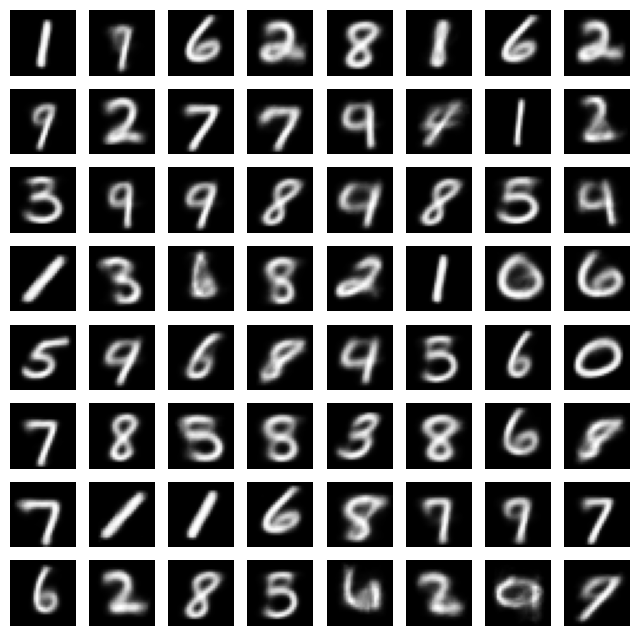

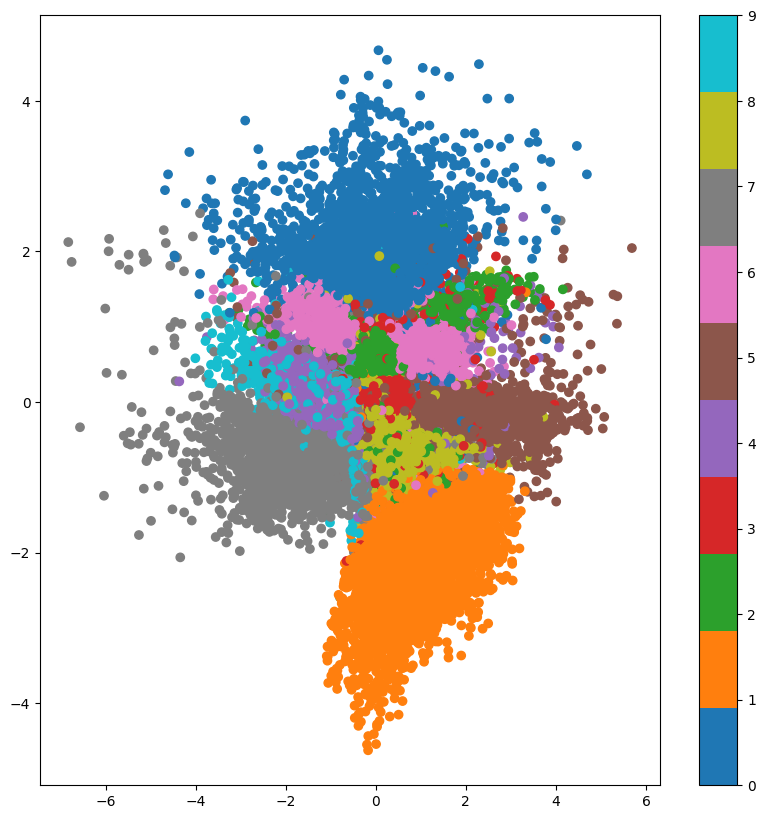

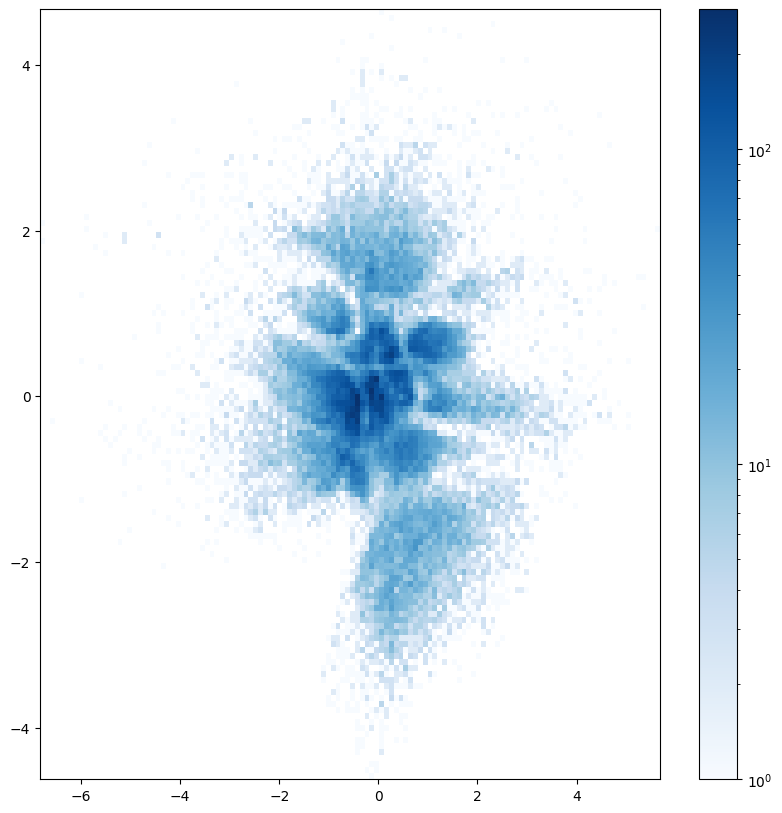

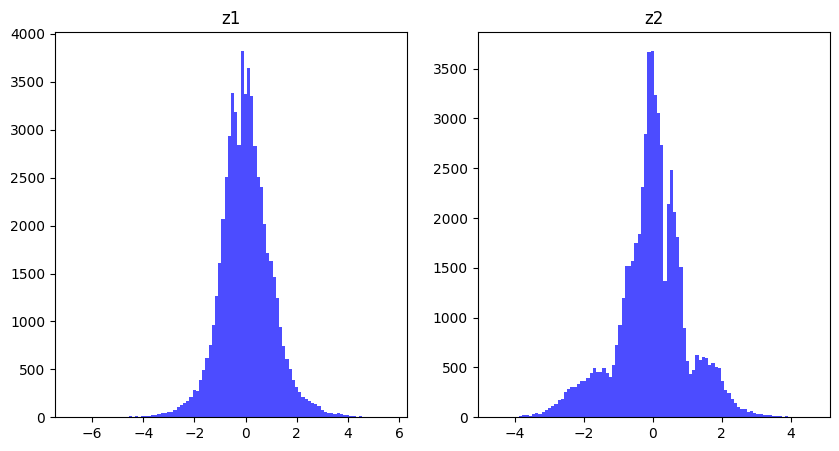

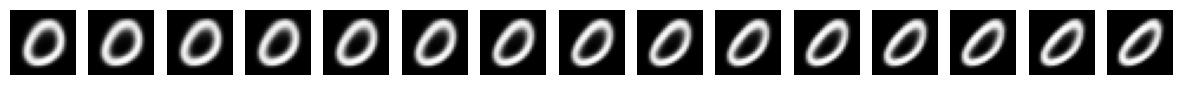

In [5]:
import matplotlib.pyplot as plt

z = torch.randn(64, latent_dim).to(device)
samples = model.decode(z)
# samples = torch.sigmoid(samples)

# print first sample
# print(samples[0])

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(
            samples[i * 8 + j].view(28, 28).cpu().detach().numpy(), cmap="gray"
        )
        ax[i, j].axis("off")

# plt.show()
plt.savefig("vae_mnist.webp")

# encode and plot the z values for the train set
model.eval()
z_all = []
y_all = []
with torch.no_grad():
    for data, target in tqdm(train_loader, desc="Encoding"):
        data = data.to(device)
        output = model(data, compute_loss=False)
        z_all.append(output.z_sample.cpu().numpy())
        y_all.append(target.numpy())
import numpy as np

z_all = np.concatenate(z_all, axis=0)
y_all = np.concatenate(y_all, axis=0)
plt.figure(figsize=(10, 10))
plt.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap="tab10")
plt.colorbar()
# plt.show()
plt.savefig("vae_mnist_2d_scatter.webp")
# plot as 2d histogram, log scale
from matplotlib.colors import LogNorm

plt.figure(figsize=(10, 10))
plt.hist2d(z_all[:, 0], z_all[:, 1], bins=128, cmap="Blues", norm=LogNorm())
plt.colorbar()
# plt.show()
plt.savefig("vae_mnist_2d_hist.webp")
# plot 1d histograms
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(z_all[:, 0], bins=100, color="b", alpha=0.7)
ax[0].set_title("z1")
ax[1].hist(z_all[:, 1], bins=100, color="b", alpha=0.7)
ax[1].set_title("z2")
# plt.show()
plt.savefig("vae_mnist_1d_hist.webp")
n = 15
z1 = torch.linspace(-0, 1, n)
z2 = torch.zeros_like(z1) + 2
z = torch.stack([z1, z2], dim=-1).to(device)
samples = model.decode(z)
samples = torch.sigmoid(samples)

# Plot the generated images
fig, ax = plt.subplots(1, n, figsize=(n, 1))
for i in range(n):
    ax[i].imshow(samples[i].view(28, 28).cpu().detach().numpy(), cmap="gray")
    ax[i].axis("off")

plt.savefig("vae_mnist_interp.webp")